In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from util import optimiser
from util import distribution

import pandas as pd
import seaborn as sns


Demiguel Nogalwes 2009 ran a model as follows:

they assume the true asset-return distribution is given as $$\mathbf{X} = 99\% \times \mathcal{N}(\mu,\Sigma) + 1\% \times D $$
where $D = \mathcal{N}(\mu_d,\Sigma_d)$ where $\Sigma_d=\Sigma$

Lim et al used the follow model:
$$ \mathbf{X} \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$$


In our scenario, we assume the stocks are generated from a multivariate T distribution
$$ \mathbf{X} \sim \mathcal{t}_{\nu}(\mathbf{\mu},\mathbf{\Sigma})$$
</p>Given $N$ risky assets the mean variance portfolio is the solution to the problem 
$$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w} - \frac{1}{\gamma}\hat{\mathbf{\mu}}^T\mathbf{w}$$ 
$$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

<p> We also seek to find the minimum-variance porfolio 
    $$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w}$$
    $$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

In [2]:
# this is the mean and covariance of the multivariate distribution
mu = np.array([26.11 , 25.21 , 28.90 , 28.68 , 24.18])
covar = np.array([[3.715 , 3.730 , 4.420 , 3.606 , 3.673],
                 [3.730 , 3.908 , 4.943 , 3.732 , 3.916],
                [4.420 , 4.943 , 8.885 , 4.378 , 5.010],
                  [3.606 , 3.732 , 4.378 , 3.930 , 3.789],
                  [3.673 , 3.916 , 5.010 , 3.789 , 4.027]])
#model = st.multivariate_normal(mean=mu,cov=covar)
model = distribution.Multivariate_T(mu,covar,3.5)

In [3]:
def mean_variance(weights,mean,cov,gamma,average=False):
    var = np.dot(np.dot(weights,cov),weights)
    mean = 1.0/gamma*np.dot(mean,weights)
    if average:
        return np.mean(var-mean,axis=0)
    else: 
        return var-mean

In [4]:
def compute_mean_variance(samples,values=()):
    if not values:
        mean = np.mean(samples,axis=0)
        cov = np.cov(samples.T)
        return (mean,cov)
    else:
        return values

In [5]:
def sum_weights(weights):
    return np.sum(weights)-1

In [6]:
init_weights = np.ones((5))/5
gamma = [10]
N = [20,50,100,200]
constraints = [{'type':'eq','fun':sum_weights}]
df = pd.DataFrame(columns=['w_star','method','gamma','N'])

In [16]:
n_iter = 200

In [21]:
N = [20,50,100,200]

In [8]:
saa = optimiser.SAA(objective_function=mean_variance,
                    constraints=constraints,
                    bounds=[(0,None)]*5,
                   helper_func=compute_mean_variance)
bagger = optimiser.BaggingSolver(iterations=200,
                                 objective_function=mean_variance,
                                constraints=constraints,
                                 bounds=[(0,None)]*5,
                                helper_func=compute_mean_variance)

In [9]:
methods = [saa,bagger]

In [22]:
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            samples = model.rvs(N[i])
            for ele in methods:
            
                w_star = ele.solve(samples,init_weights,additional_args=(gamma[j],False))   
                results = {'w_star': w_star,'method':ele.__str__(),'gamma':gamma[j],'N':N[i]}
                df = df.append(results,ignore_index=True)
            
    w_star = ele.solve(samples,
                       init_weights,
                       additional_args=(gamma[j],False),
                       values=(mu,covar))         
    results = {'w_star': w_star,'method':'True','gamma':gamma[j],'N':N[i]}
    df = df.append(results,ignore_index=True)

In [23]:
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(mu,x))
df['mean_variance'] = df.apply(lambda x:mean_variance(x['w_star'],
                                                      mu,
                                                      covar,
                                                      x['gamma']),
                                axis=1)

In [24]:
gamma_df = df[df['gamma']==10.0]

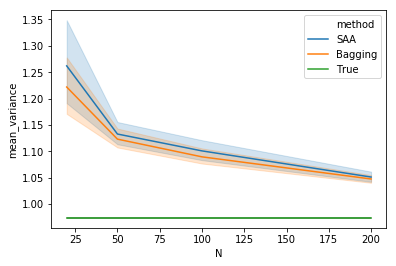

In [27]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*len(N),color='g')